In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

import torch

from datasets import load_dataset, Dataset
from datasets import Features, Value, ClassLabel

from transformers import BertTokenizer
from transformers import BertForSequenceClassification

from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate

/Users/gabrielasiqueiraeduardo/miniforge3/envs/unstructured_nlp/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load dataset

#### pandas dataset

In [2]:
df = pd.read_csv('dataset/dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
# contagem simples de "palavras"
df['text_length'] = df['text'].apply(lambda x: len(x.split(' ')))

<AxesSubplot: >

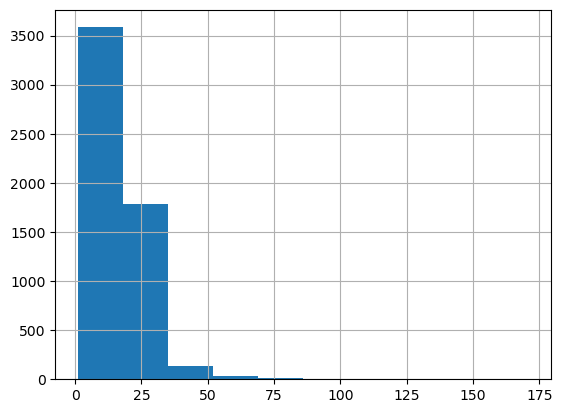

In [7]:
df['text_length'].hist()

In [8]:
# balance classes

df_spam = df[df['label'] == 'spam']
df_ham = df[df['label'] == 'ham']

# undersampling
df_downsampled = resample(df_ham, replace=False, n_samples=len(df_spam), random_state=42)

df_balanced = pd.concat([df_downsampled, df_spam])


In [9]:
df_balanced.label.value_counts()

ham     747
spam    747
Name: label, dtype: int64

In [10]:
df_balanced.drop(columns=['text_length']).to_csv('dataset/spam_downsampled.csv', index=False)

In [11]:
df = pd.read_csv('dataset/spam_downsampled.csv')

In [12]:
df

,label,text
0,ham,"I am late,so call you tomorrow morning.take ca..."
1,ham,U r too much close to my heart. If u go away i...
2,ham,Wait &lt;#&gt; min..
3,ham,Can you call me plz. Your number shows out of ...
4,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...
...,...,...
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...


#### torch dataset

In [13]:
class_names = ['ham', 'spam']

ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

In [14]:
dataset = load_dataset('csv', data_files=['dataset/spam_downsampled.csv'], features=ft)['train'].train_test_split(train_size=.8, test_size=.2, stratify_by_column="label")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [15]:
dataset_train = dataset['train'].shuffle(seed=42)
dataset_test = dataset['test'].shuffle(seed=42)

## BERT tokenizer

In [16]:
model_id = "bert-base-cased"

tokenizer = BertTokenizer.from_pretrained(model_id, do_lower_case=False)

In [17]:
token_length = list()
for text in df['text']:
    tokens = tokenizer.tokenize(text)
    token_length.append(len(tokens))

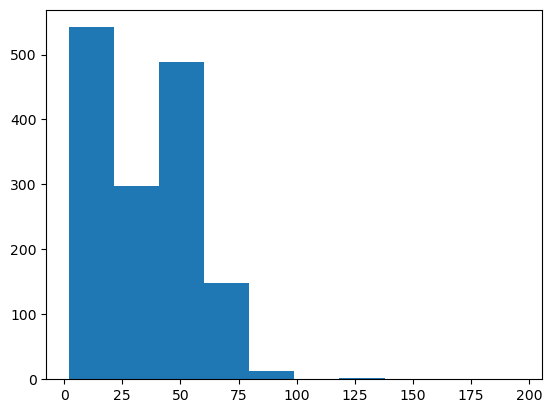

In [18]:
# token lenght < max_length  --- no need for chunking method
plt.hist(token_length);

In [19]:
def tokenization(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

dataset = dataset.map(tokenization, batched=True, remove_columns=["text"])
dataset

Map:   0%|          | 0/1195 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1195
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 299
    })
})

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [22]:
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [23]:
training_args = TrainingArguments(
    output_dir="spam_torch",
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    logging_steps=1000,
    load_best_model_at_end=True,
    seed=42
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/Users/gabrielasiqueiraeduardo/miniforge3/envs/unstructured_nlp/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.05795900523662567, 'eval_accuracy': 0.9866220735785953, 'eval_runtime': 12.5245, 'eval_samples_per_second': 23.873, 'eval_steps_per_second': 3.034, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.035301078110933304, 'eval_accuracy': 0.9899665551839465, 'eval_runtime': 12.5679, 'eval_samples_per_second': 23.791, 'eval_steps_per_second': 3.024, 'epoch': 2.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.06277454644441605, 'eval_accuracy': 0.9832775919732442, 'eval_runtime': 12.1282, 'eval_samples_per_second': 24.653, 'eval_steps_per_second': 3.133, 'epoch': 3.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.0378713458776474, 'eval_accuracy': 0.9933110367892977, 'eval_runtime': 12.1266, 'eval_samples_per_second': 24.657, 'eval_steps_per_second': 3.134, 'epoch': 4.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.036000803112983704, 'eval_accuracy': 0.9933110367892977, 'eval_runtime': 12.2433, 'eval_samples_per_second': 24.421, 'eval_steps_per_second': 3.104, 'epoch': 5.0}
{'train_runtime': 1056.5215, 'train_samples_per_second': 5.655, 'train_steps_per_second': 0.71, 'train_loss': 0.0745343017578125, 'epoch': 5.0}


TrainOutput(global_step=750, training_loss=0.0745343017578125, metrics={'train_runtime': 1056.5215, 'train_samples_per_second': 5.655, 'train_steps_per_second': 0.71, 'train_loss': 0.0745343017578125, 'epoch': 5.0})

## Validation

In [25]:
def predict(text):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors='pt').to('mps')
    outputs = model(**encoding)
    preds = torch.sigmoid(outputs.logits)
    return preds

In [29]:
texts = [
    "Hey! Just wanted to remind you about our dinner plans tonight at 7 PM. Can't wait to catch up!", # ham
    "Your prescription is ready for pickup at the pharmacy. Please stop by at your convenience.", # ham
    "Hi, this is John from the office. Could you please bring the report to the meeting room in 10 minutes? Thanks!", # ham
    "Congratulations! You've won a $1000 gift card. Claim it now by clicking the link: bit.ly/claimprize123", # spam
    "Urgent: Your entry was selected! You've won a luxury vacation for two. Call now to claim: 555-1234.", # spam
    "FreeMsg: You have been selected for a free iPhone 12! Reply 'YES' to claim your prize. T&C apply." # spam
        ]


In [30]:
for text in texts:
    print(text)
    preds = predict(text)
    print(f'Ham: {preds[0][0]}, Spam: {preds[0][1]}')

Hey! Just wanted to remind you about our dinner plans tonight at 7 PM. Can't wait to catch up!
Ham: 0.9346007108688354, Spam: 0.1136571615934372
Your prescription is ready for pickup at the pharmacy. Please stop by at your convenience.
Ham: 0.8376519680023193, Spam: 0.22955235838890076
Hi, this is John from the office. Could you please bring the report to the meeting room in 10 minutes? Thanks!
Ham: 0.9221779108047485, Spam: 0.10321135073900223
Congratulations! You've won a $1000 gift card. Claim it now by clicking the link: bit.ly/claimprize123
Ham: 0.018333636224269867, Spam: 0.9606122374534607
Urgent: Your entry was selected! You've won a luxury vacation for two. Call now to claim: 555-1234.
Ham: 0.02043386548757553, Spam: 0.9676923155784607
FreeMsg: You have been selected for a free iPhone 12! Reply 'YES' to claim your prize. T&C apply.
Ham: 0.03853880614042282, Spam: 0.884552538394928
